# TP_1 Computational statistics 

## Context:
In the exercise, we consider the problem of classifying patterns x into two classes y = ±1.
We assume that there is a relationship between a pattern and its class, embodied by some
probability distribution P(x, y). If we know this distribution, we know the conditional probabilities P(y|x) as well, and we can solve immediately the problem using the Bayes decision
rule. 

The statistical machine learning approach begins with the collection of a sizeable set of
examples {(x1, y1), . . . ,(xn, yn)}, where for each i ∈ J1, nK the vector xi represents the features
and the scalar yi a label indicating whether xi belongs (yi = 1) or not (yi = −1) to a particular class. With such a set of examples, one can construct a classification program, defined
by a prediction function h, and measure its performance by counting how often the program
prediction h(xi) differs from the correct prediction yi
. To avoid rote memorization, one should
aim to find a prediction function that generalizes the concepts that may be learned from the
examples. One way to achieve good generalized performance is to choose amongst a carefully
selected class of prediction functions.




## Imports


In [1]:
import numpy as np 
import pylab as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## QUESTION 1: Stochastic grqdient descent from scratch 




Describe the stochastic gradient descent algorithm for minimizing the empirical risk and
implement it.

To start the empiral risk is given by :

$$ R_n(w) = \mathbb{E}\left[ J(w, z) \right] = \dfrac{1}{n} \sum_{i = 1}^n \left( y_i - w^\mathsf{T} x_i \right)^2 $$

where


*   $z​=(x,y)$ the observations
*   $J(w, z)$ the loss function for a certain $w$

For the stocastique gradient descent:


1.   We compute the gradient of $J$ on $w$: 
$$ \nabla_w J(w, z) = - 2 \left( y - w^\mathsf{T} x \right) x $$

2.   Then with the convergence hypotisis the gradient should be bounded. but in this case with $x$ non zero value and $w=λx$ when $λ$ tends to infinity the gradient is clearly unbounded. Hence we project on the unit sphere:
$$ \left\| \nabla_w J(w, z) \right\| \leqslant 2 \left( 1 + \| x \| \right) \, \| x \| $$
As our number of observations is finite, the norm of x is bounded so the gradient is well bounded. This projection does not modify the set of obtainable hyperplanes because the norm of w has no influence on the hyperplane.

3. Finally  $J$ satisfies the rest of the properties for  a sequence $(\epsilon_k){k > 0}$ verifying the convergence hypotheses:
$$  \sum{} \epsilon_{k} = + \infty $$
$$\qquad \sum_{k > 0} \epsilon_k^2 < + \infty $$

The following algorithm then converges to an optimal solution: 

Pseudo-code:

While $k ≤ K$ and $\lvert \mathbb{E}\left[ \nabla_w J(w, z) \right] \rvert ≥ τ $:

we start with $w_0$ and the decreasing sequence $(\epsilon_k){k > 0}$ towards 0.

For each iteration :

*  we randomly choose an element in the set $z(k) ∈ \left\{ {zi = (xi, yi)}\right\}$

*  $w_{k+1} =w_k −ε_k \nabla_{w_k} j(w_k,z(k))$
*  $k=k+1$


***We start by implementing the pseudo code above of the stocastic gradient descent***

In [3]:
def SGD(Z, w0, EPS, K): 
  '''
  Compute the stocastic gradient descent algorithm for a singular feature 
  returns the optimal hyperplane 'w' that seprates the observations
  
  Input
  ------------
  Z : list of observations
	w0 : array of float
		Represent the hyperplane used to start the algorithm
	eps : float generator
		This generator is used to scale the updates of the `w`
	K : int
		Maximal number of steps of the algorithm
  '''

  w=w0.copy()
  for k in range(K):
    #we randomly choose elements from Z
    X,Y= Z[np.random.randint(len(Z))]
    #Update W
    eps=next(EPS)
    w-=eps*(- 2* (Y-np.dot(w,X) ) * X)
    #projection on unit sphere
    w /= np.linalg.norm(w)

  return w

***For epsilon we can compute a function that generates a squence that satisfies the convergence criteria***
 Typically we use the inverse sequence since it satisfies the criteriea and is simple to implement 

In [4]:
def inverseSeq():
	"""
	Generator of the infinite sequence of inversed integers
	"""
	n = 1
	while True:
		yield 1 / n
		n += 1

## QUESTION 2 : Generation of binary dataset 


*Generation of a binary dataset*

In this section the goal is to sample a set of observations $\left\{ z_i \right\} _{i=1}^n$  by generating a collection of random points $x_i$  then a normal vector of a hyperplane then assigning $y_i$ de pending on the side of the hyperplane 


1.   generate a vector $W$
2.   generate X and label them depending on the side of the hyperplane



In [6]:
from matplotlib.pylab import vectorize
from random import gauss

def generate_rand_vector(dimension=2):
  '''
  return a random vector
  '''
  vec = np.array([gauss(0, 1) for i in range(dimension)])
  return vec

def generate_binary_sample(n): 
  '''
  Generates a binary sample seperated by a hyperplane
  '''
  w=generate_rand_vector()
  w=w/np.linalg.norm(w)
  print("Data generated with w =", w)

  sample = []
  for _ in range(n):
    x =  generate_rand_vector()
    y = 1 if np.dot(w, x) > 0 else -1
    sample.append([x, y])

  return sample ,w

### Visualization 

In [7]:
def plot_binarydata_sep(Z, w):
  '''
  Plot binary dataset and seperation 

  parameters
  ---------
  Z : list of observations (vector, labels)
	w : array of float
		Represent the normal vector of the hyperplane to plot
  '''
  plt.clf()

  #scatter plots for binary data 
  X={1:[], -1:[]}
  Y={1:[], -1:[]}
  for x,y in Z:
    X[y].append(x[0])  
    Y[y].append(x[1]) 
  plt.scatter(X[1],Y[1], color='orange')
  plt.scatter(X[-1],Y[-1], color='b')

  #plot seperation 
  sep =  3*np.array((-w[1], w[0]))
  plt.plot([-sep[0], sep[0]], [-sep[1], sep[1]], color='black')[0]

  plt.title('data and separation plot')
  plt.show()


Data generated with w = [ 0.68616491 -0.72744602]


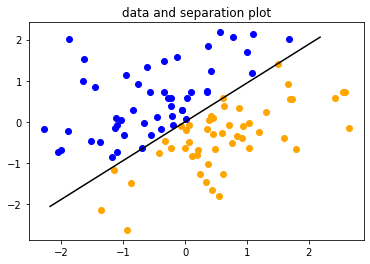

In [8]:
#Example
Z, w = generate_binary_sample(100)

plot_binarydata_sep(Z,w)

## QUESTION 3: Testing SGD


In this section we are going to compare the original $w$ to the estimated one with stocastic gradient descent 

In [9]:
def accuracy(Z,w_estimated):
  '''
  Computes the accuracy of the seperation using the normal vector of the hyperplane 
   parameters
  ---------
  Z : list of observations (vector, labels)
	w : array of float
		Represent the estimated normal vector of the hyperplane to plot
  '''
  correct = 0
  for x, y in Z:
    if y*np.dot(w_estimated, x) > 0: correct += 1
  return correct /len(Z)


Data generated with w = [ 0.8233887 -0.5674778]
the real hyperplane vector w= [ 0.8233887 -0.5674778]
the estimated hyperplane vector w= [ 0.86581394 -0.50036608]
the accuracy is 0.98
#######################
we can compare the plots


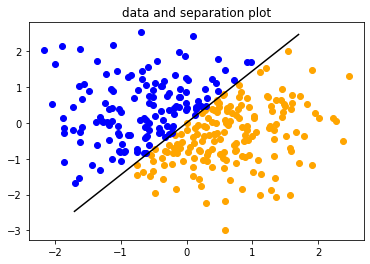

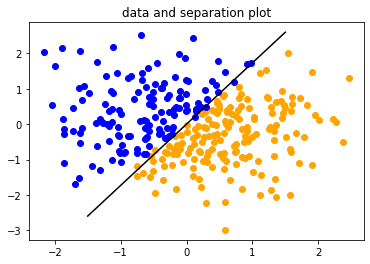

In [10]:
#TEST

#input
N=300
K=200
w0=generate_rand_vector()

#generate samples:
Z, w=generate_binary_sample(N)
w_estimated=SGD(Z,w0, inverseSeq(),K)
acc=accuracy(Z,w_estimated)
#results:
print('the real hyperplane vector w=',w )
print('the estimated hyperplane vector w=',w_estimated )
print('the accuracy is',acc)
print('#######################')
print('we can compare the plots')

plot_binarydata_sep(Z,w)
plot_binarydata_sep(Z,w_estimated)

## Question 4: Noise 

In this question we add noise to the generated data and compare the results to question 3

In [11]:
def addGaussian(Z, sigma):
  Z_noise=Z.copy()
  return [[x+np.random.normal(np.array([0, 0]), sigma),y] for x,y in Z_noise]


Data generated with w = [ 0.84419716 -0.5360328 ]
the estimated hyperplane vector w= [ 0.87760098 -0.47939183]
the accuracy for no noise is 0.97
the estimated hyperplane vector with noise w= [ 0.8452735 -0.5343339]
the accuracy with the noise is 0.85
#######################
we can compare the plots


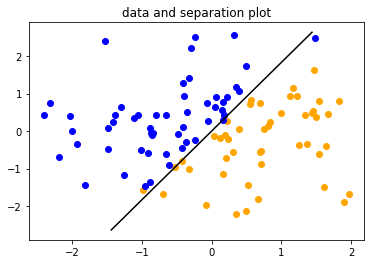

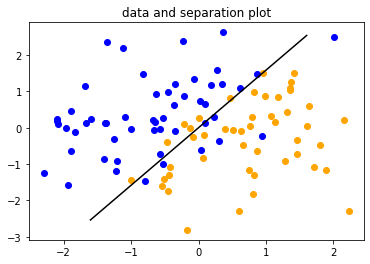

In [12]:
#input
N=100
K=200
sigma=0.3
w0=generate_rand_vector()

#generate samples:
Z, w=generate_binary_sample(N)
w_estimated=SGD(Z,w0, inverseSeq(),K)
acc=accuracy(Z,w_estimated)

Z_noise=addGaussian(Z,sigma)
w_estimated_noise=SGD(Z_noise,w0, inverseSeq(),K)
acc_noise=accuracy(Z_noise,w_estimated_noise)
#results:
print('the estimated hyperplane vector w=',w_estimated )
print('the accuracy for no noise is',acc)
print('the estimated hyperplane vector with noise w=',w_estimated_noise )
print('the accuracy with the noise is',acc_noise)
print('#######################')
print('we can compare the plots')

plot_binarydata_sep(Z,w_estimated)
plot_binarydata_sep(Z_noise,w_estimated_noise)

**We notice that the accuracy decreaces after adding the noise**

## Question 5: 

### data preprocessing

In [20]:
import pandas as pd
# reading csv files
X =  np.array(pd.read_csv('/content/drive/MyDrive/MVA/Computational statistics/ASSIGNMENT /HW1/data/breast-cancer-wisconsin.data', sep=",",index_col=[0,10]))
Y=np.array(pd.read_csv('/content/drive/MyDrive/MVA/Computational statistics/ASSIGNMENT /HW1/data/breast-cancer-wisconsin.data', sep=",",index_col=list(range(10))))
Y-=[[3]]*len(Y)
Z=[]
for i in range(len(Y)):
  if '?' in X[i]: continue #we remove the'?' character
  #normilize min max 
  max=10 
  min=0
  dim=9
  M=(max-min)//2
  x = (np.array(list(map(float, X[i]))) - M) / (dim*M**2) ** 0.5

  Z.append([x,Y[i][0]])


### Classification

In [21]:
K=1000
w0 = generate_rand_vector(dimension=9)
w_opt = SGD(Z, w0, inverseSeq(), K)
print("Hyperplan learned w =", w_opt)
print("Obtained score (ratio of well predicted observations) is s =", accuracy(Z, w_opt))


Hyperplan learned w = [0.40775987 0.41059736 0.39576285 0.27098319 0.21964029 0.46615955
 0.30537939 0.25897402 0.09597333]
Obtained score (ratio of well predicted observations) is s = 0.9413489736070382
